In [6]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_roc_curve, roc_curve  
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from scipy.stats import randint
import time
import warnings
from pprint import pprint

#from rdea.eval.cross_validation import do_cross_validation, do_cross_validation_with_feature_selection
#from rdea.filters.embedded import EmbeddedFilter
#from rdea.filters.mrmr import MRMRP
#from rdea.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs

# Read data from excel file and extract ID, features of gen
cols = [2, 8, 9, 10, 11, 12, 13, 14] 
df = pd.read_excel (r'C:\Users\nguye\joon_first_test\original_data\U1_vs_T76 original.xlsx', sheet_name='Sheet1',usecols=cols) #,skiprows=3)
#print (df) #print (df.iloc[-1]) #print (df.head(1)) 
features = ['NCBI_ID', 'Max group mean', 'Log₂ fold change', 'Fold change', 'P-value', 'FDR p-value','Bonferroni']

print('Total length of df : ',len(df))

# check present of missing values in whole df
if (df.isnull().any().any()): 
    print('remove rows with missing values')
    tot_null_val = [pd.isna(df[features[0]]).sum(axis=0), pd.isna(df[features[1]]).sum(axis=0),
                    pd.isna(df[features[2]]).sum(axis=0), pd.isna(df[features[3]]).sum(axis=0),
                    pd.isna(df[features[4]]).sum(axis=0), pd.isna(df[features[5]]).sum(axis=0),
                    pd.isna(df[features[6]]).sum(axis=0)]
#    print(tot_null_val)
    index_feat = []
    for i in range(0, len(tot_null_val)):
        if tot_null_val[i] != 0: index_feat.append(i)
#    print(type(index_feat))
    
    for j in range(len(index_feat)):
        feat_process = features[(index_feat[j])]
#        print(feat_process)    
        ind_remove = np.where(df[feat_process].isnull())[0]
#        print(ind_remove)
        for k in range(0,len(ind_remove)):
            df = df.drop(ind_remove[k], axis=0)
    print('length of df : ',len(df))    

else: print('no missed values')
    
print(df.shape) 
print(df.iloc[0,1:8])   

Total length of df :  904
no missed values
(904, 8)
Max group mean        568.953
Log₂ fold change     0.535368
Fold change              1.45
P-value             0.0233028
FDR p-value         0.0855273
Bonferroni                  1
Group                     T76
Name: 0, dtype: object


In [7]:
# removal of dulicates
df = df.drop_duplicates('NCBI_ID', keep="last")
index_names = df[ df['NCBI_ID'] == '-' ].index
df.drop(index_names, inplace = True)
print(df.shape) 
df.index = np.arange(0,len(df))
#print(df)
print('length of df : ',len(df))

(888, 8)
length of df :  888


In [8]:
# labeling 0 for U1 and 1 for T76
ground_true = []
for i in range(0,len(df)):
    if df['Group'][i] == 'U1': ground_true.append(0)
    else: ground_true.append(1)
ground_true = np.array(ground_true)
print(ground_true.shape)

(888,)


In [9]:
# Convert data from pandas into number
data_process = df[:].values
#print(data_process.shape)
data_process = data_process[:,1:7]
data_process = np.array(data_process)
#print (input_data.shape)
# data normalization
data_process = (data_process - data_process.min()) / (data_process.max() - data_process.min())
print (data_process.shape)

(888, 6)


In [10]:
# convert data_process to DataFrame for plot
dff = pd.DataFrame(data_process, columns = ['Max group mean', 'Log₂ fold change', 
                                            'Fold change', 'P-value', 'FDR p-value','Bonferroni'])

<Figure size 432x288 with 0 Axes>

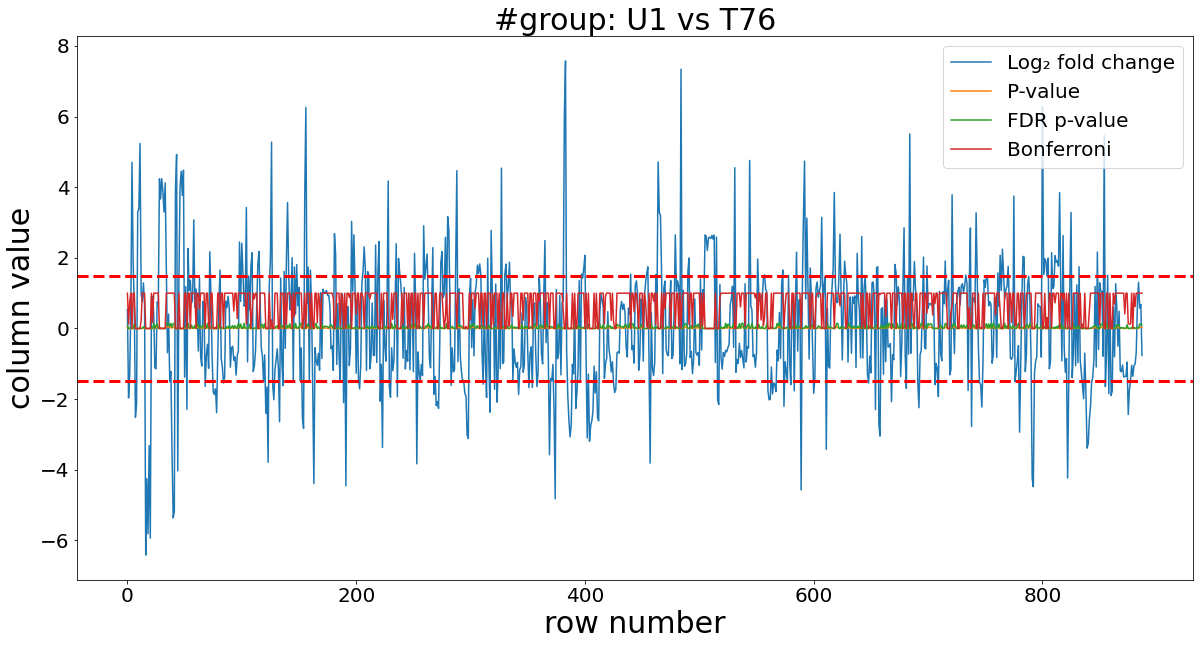

<Figure size 432x288 with 0 Axes>

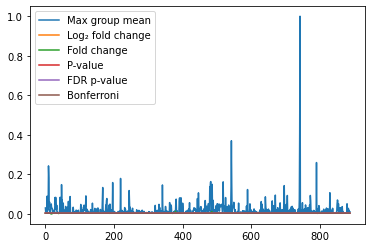

In [11]:
# Data visualization
# line plot
# raw data
plt.figure()
ax = df[['Log₂ fold change','P-value', 'FDR p-value','Bonferroni']].plot(figsize=(20,10))
ax.axhline(linewidth=3, linestyle = '--', color='r', y=1.5)
ax.axhline(linewidth=3, linestyle = '--', color='r', y=-1.5)
ax.set_xlabel("row number", size = 30)
ax.set_ylabel("column value", size = 30)
ax.set_title('#group: U1 vs T76', fontdict={'fontsize': 30, 'fontweight': 'medium'})
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
plt.legend(fontsize=20)    
plt.show()
# normalized data
plt.figure()
dff.plot()
plt.show()

In [12]:
# Separate data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(data_process, ground_true, test_size = 0.40, random_state = 101)


In [13]:
# Tuning parameters and check performance of optimal model
def hyperparameter_tune(base_model, parameters, n_iter, kfold, X=X_train, y=Y_train):
    start_time = time.time()       
    # Arrange data into folds with approx equal proportion of classes within each fold
    k = StratifiedKFold(n_splits=kfold, shuffle=False)
    
    optimal_model = RandomizedSearchCV(estimator = base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            verbose= 2,
                            random_state=101,
                            scoring = 'accuracy')
    
    optimal_model.fit(X, y)
    stop_time = time.time()
    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="accuracy")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    print("Best model: {}".format(optimal_model.best_estimator_))
    
    return optimal_model.best_params_, optimal_model.best_score_, optimal_model.best_estimator_

base_model = RandomForestClassifier(n_jobs=-1, random_state=101)

random_search = {'criterion': ['entropy', 'gini'],
                 'bootstrap': [True],
                 'max_depth': [30, 40, 50, 60, 70, 80, 90, 100, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [10, 20, 30],
                 'n_estimators': [500, 1000, 1200, 1500, 2000, 2500, 3000]}

best_params, best_score, best_estimator = hyperparameter_tune(base_model, random_search, 10, 3, X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   56.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   56.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.1s finished


Elapsed Time: 00:01:37
Cross Val Mean: 1.000, Cross Val Stdev: 0.000
Best Score: 1.000
Best Parameters: {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': True}
Best model: RandomForestClassifier(criterion='entropy', max_depth=90, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1200, n_jobs=-1, random_state=101)



cv =  2
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   18.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   25.5s finished


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   17.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   23.3s finished


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   17.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.9s finished


Elapsed Time: 00:00:28
Cross Val Mean: 1.000, Cross Val Stdev: 0.000
Best Score: 1.000
Best Parameters: {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': True}
Best model: RandomForestClassifier(criterion='entropy', max_depth=90, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1200, n_jobs=-1, random_state=101)

cv =  3
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   44.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


Elapsed Time: 00:00:54
Cross Val Mean: 1.000, Cross Val Stdev: 0.000
Best Score: 1.000
Best Parameters: {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': True}
Best model: RandomForestClassifier(criterion='entropy', max_depth=90, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1200, n_jobs=-1, random_state=101)


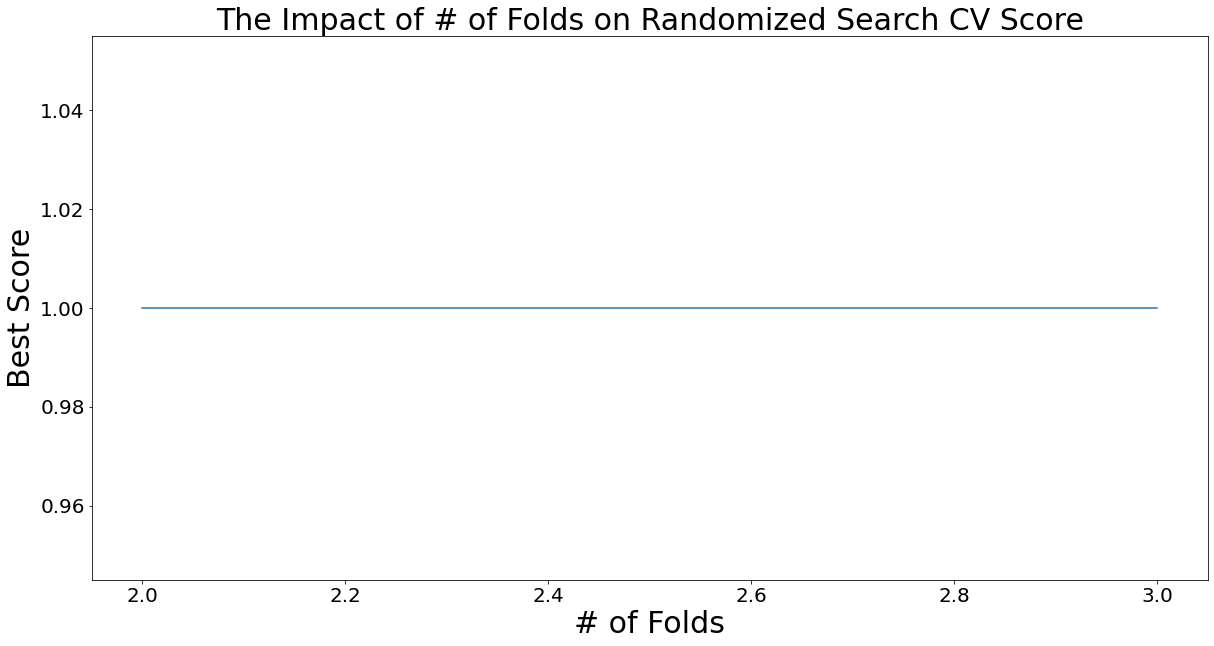

In [14]:
# Folds plot
scores = []
folds = range(2, 4)

for i in folds:
    print("\ncv = ", i)
    best_params1, best_score1, best_estimator1 = hyperparameter_tune(base_model, random_search, 10, i, X_train, Y_train)
    scores.append(best_score)
    
plt.figure(figsize=(20,10))  
plt.plot([x for x in folds], scores)
plt.xlabel("# of Folds", size = 30)
plt.ylabel("Best Score", size = 30)
plt.title("The Impact of # of Folds on Randomized Search CV Score", fontdict={'fontsize': 30, 'fontweight': 'medium'})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

[1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1
 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1
 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0
 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0
 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0
 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0]


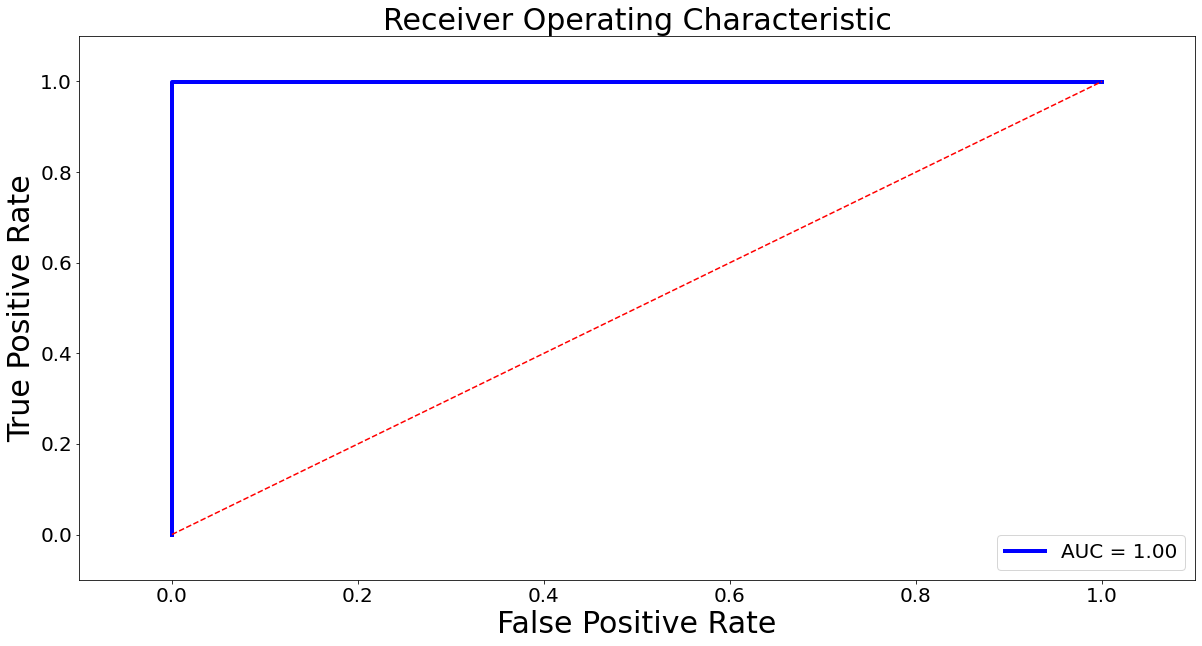

In [16]:
# classification and ROC  curve on test set
best_estimator.fit(X_train,Y_train)
y_pred = best_estimator.predict(X_test)
print(y_pred)
#plt.figure()
##plt.show()

probs = best_estimator.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(20,10)) 
plt.title('Receiver Operating Characteristic', fontdict={'fontsize': 30, 'fontweight': 'medium'})
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth = 4.0)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate', size = 30)
plt.xlabel('False Positive Rate', size = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
leg = plt.legend(loc="lower right", prop={"size":20})
plt.show()


[1 0 0 1 1 1 1 0 0]
[[0.04687344 0.95312656]
 [0.98611997 0.01388003]
 [0.98571545 0.01428455]
 [0.01456991 0.98543009]
 [0.04725488 0.95274512]
 [0.01553835 0.98446165]
 [0.02994963 0.97005037]
 [0.94425893 0.05574107]
 [0.97531146 0.02468854]]


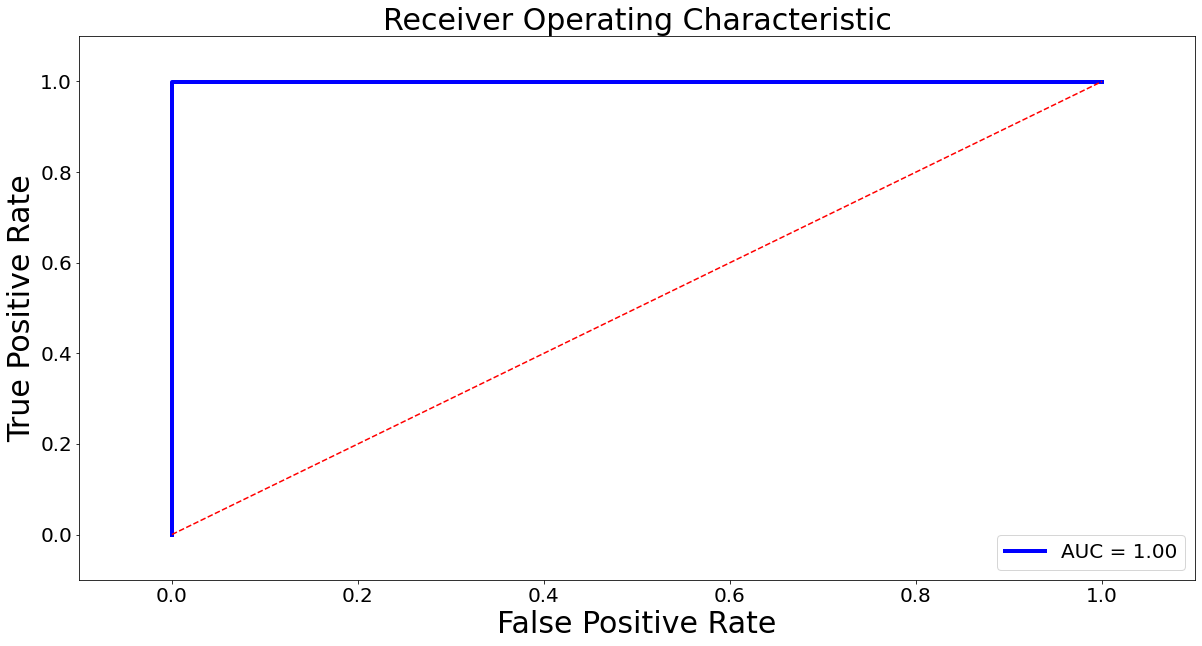

In [17]:
# Calculate probability of all data samples
best_estimator.fit(X_train,Y_train)
probability = best_estimator.predict_proba(data_process)
y_pred = best_estimator.predict(data_process)
print(y_pred[0:9])
row = probability[0:9,:]
print(row)

preds = probability[:,1]
fpr, tpr, threshold = roc_curve(ground_true, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(20,10)) 
plt.title('Receiver Operating Characteristic', fontdict={'fontsize': 30, 'fontweight': 'medium'})
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth = 4.0)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate', size = 30)
plt.xlabel('False Positive Rate', size = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
leg = plt.legend(loc="lower right", prop={"size":20})
plt.show()


In [18]:
# Creat dataframe with probability and feature names
output_data = pd.DataFrame(df.iloc[:,0])
output_data.columns = ['gene_ID']
dfram = pd.DataFrame(probability[:,1])
dfram.columns =['up_case_prob']
output_data['up_case_prob'] = dfram 
print(output_data)

          gene_ID  up_case_prob
0       YP_500313      0.953127
1       YP_500220      0.013880
2       YP_499933      0.014285
3       YP_501152      0.985430
4       YP_498713      0.952745
..            ...           ...
883     YP_500457      0.988507
884     YP_500208      0.984059
885     YP_500017      0.963758
886     YP_501148      0.969200
887  WP_000046705      0.049769

[888 rows x 2 columns]


In [19]:
# Sorting decending
output_data.sort_values(by=['up_case_prob'], inplace=True, ascending=False)
print(output_data)

          gene_ID  up_case_prob
300     YP_498716      0.994716
557     YP_498715      0.992959
804     YP_501493      0.992481
813  WP_001035802      0.991709
619     YP_499362      0.991145
..            ...           ...
877  WP_002447295      0.007514
119  WP_000931871      0.007071
873     YP_498772      0.006958
868     YP_499898      0.006087
869     YP_499896      0.005666

[888 rows x 2 columns]


In [20]:
# Select 100 genes based on probability
first = output_data[:50]
last = output_data[-50:]
#print(first)
#print(last)
first = first.append(last, ignore_index=True)
selected_genes = pd.DataFrame(first)
print(selected_genes)

         gene_ID  up_case_prob
0      YP_498716      0.994716
1      YP_498715      0.992959
2      YP_501493      0.992481
3   WP_001035802      0.991709
4      YP_499362      0.991145
..           ...           ...
95  WP_002447295      0.007514
96  WP_000931871      0.007071
97     YP_498772      0.006958
98     YP_499898      0.006087
99     YP_499896      0.005666

[100 rows x 2 columns]


In [21]:
# Export to excel file
selected_genes.to_excel(r'C:\Users\nguye\joon_first_test\selected_genes\U1_vs_T76_selected_gene.xlsx', index = False)
